In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os,sys
import h5py
import time
import glob
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import LearningRateScheduler, ModelCheckpoint
from keras.models import Sequential
from keras.models import load_model
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import SGD, Adam
from mpl_toolkits.axes_grid1 import AxesGrid



labels = []
images = []

batch_size = 100
epochs = 150
classes = os.listdir('./characters/')
num_classes = len(os.listdir('./characters/'))-1
test_size = 0.2

/home/user/anaconda3/envs/tensorflow/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
def load_data(root_path):
    for i, folder_path in enumerate(glob.glob(root_path + "*")):
        
        print("Store the dataset ~~~~~~~~~~~~~~~~~~~~~~~")
        print(folder_path + ":")
        
        images_path = glob.glob(folder_path + "/*.jpg")
        
        for index, image_path in enumerate(images_path):
            image = cv2.resize(cv2.imread(image_path),(64,64))
            images.append(image)
            labels.append(i)
            ### 顯示進度
            percent = int(((index + 1 ) / len(images_path)) * 100)
            string = '■' * percent + ' ' * ((100 - percent))    ## 
            sys.stdout.write('\r' + string +"%s%% [%d/%d]" % (percent, index, len(images_path)))   ## 顯示結果
            sys.stdout.flush()    ## 字刷掉重來
            time.sleep(0.01)
            
        print(" ") 
    return labels, images

In [3]:
def read_main(root_path, save = False, load = False):
    star_time = time.time()
    if load:
        h5f = h5py.File('dataset.h5','r')
        X_train = h5f['X_train'][:]
        X_test = h5f['X_valid'][:]
        h5f.close()    

        h5f = h5py.File('labels.h5','r') 
        y_train = h5f['y_train'][:]
        y_test = h5f['y_valid'][:]
        h5f.close()  
    
    else:
        labelList, imageList = load_data(root_path)
        img_arr = np.array(imageList)
        enc = OneHotEncoder()
        label_arr = np.array(labelList).reshape(-1,1)
        labels = enc.fit_transform(label_arr).toarray() 
        X_train, X_test, y_train, y_test = train_test_split(img_arr, labels, test_size=test_size)
        if save:
            h5f = h5py.File('dataset.h5', 'w')
            h5f.create_dataset('X_train', data=X_train)
            h5f.create_dataset('X_valid', data=X_test)
            h5f.close()

            h5f = h5py.File('labels.h5', 'w')
            h5f.create_dataset('y_train', data=y_train)
            h5f.create_dataset('y_valid', data=y_test)
            h5f.close()
    end_time = time.time()
    time_totl = end_time - star_time
    X_train = X_train.astype('float32') / 255
    X_test = X_test.astype('float32') / 255   
    print("Train", X_train.shape, y_train.shape)
    print("Test", X_test.shape, y_test.shape)
    print("time: ",time_totl,"seconds")
    return X_train, X_test, y_train, y_test

In [4]:
def create_model_six_conv(input_shape):
    """
    CNN Keras model with 6 convolutions.
    :param input_shape: input shape, generally X_train.shape[1:]
    :return: Keras model, RMS prop optimizer
    """
    model = Sequential()
    model.add(Conv2D(32, (3, 3), padding='same', input_shape=input_shape))
    model.add(Activation('relu'))
    model.add(Conv2D(32, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.5))

    model.add(Conv2D(64, (3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(Conv2D(64, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.5))

    model.add(Conv2D(128, (3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(Conv2D(128, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.5))   

    model.add(Conv2D(256, (3, 3), padding='same')) 
    model.add(Activation('relu'))
    model.add(Conv2D(256, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.5))

    model.add(Flatten())
    model.add(Dense(1024))
    model.add(Activation('relu'))
    # model.add(Flatten())
    # model.add(Dense(512))
    # model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    # opt = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
    opt = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
    print(model.summary())
    return model, opt

In [5]:
def training(model, X_train, X_test, y_train, y_test, data_augmentation=False):
    """
    Training.
    :param model: Keras sequential model
    :param data_augmentation: boolean for data_augmentation (default:True)
    :param callback: boolean for saving model checkpoints and get the best saved model
    :param six_conv: boolean for using the 6 convs model (default:False, so 4 convs)
    :return: model and epochs history (acc, loss, val_acc, val_loss for every epoch)
    """
    start_time = time.time()
    if data_augmentation:
        datagen = ImageDataGenerator(
            featurewise_center=False,  # set input mean to 0 over the dataset
            samplewise_center=False,  # set each sample mean to 0
            featurewise_std_normalization=False,  # divide inputs by std of the dataset
            samplewise_std_normalization=False,  # divide each input by its std
            zca_whitening=False,  # apply ZCA whitening
            rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
            width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
            height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
            horizontal_flip=True,  # randomly flip images
            vertical_flip=False,
            )  # randomly flip images
        # Compute quantities required for feature-wise normalization
        # (std, mean, and principal components if ZCA whitening is applied).
        datagen.fit(X_train)
        filepath="weights_6conv_%s.hdf5" % time.strftime("%d%m/%Y")
        checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=0, save_best_only=True, mode='max')
        callbacks_list = [LearningRateScheduler(lr_schedule) ,checkpoint]
        history = model.fit_generator(datagen.flow(X_train, y_train,
                                    batch_size=batch_size),
                                    steps_per_epoch=X_train.shape[0] // batch_size,
                                    epochs=40,
                                    validation_data=(X_test, y_test),
                                    callbacks=callbacks_list)        
    else:
        history = model.fit(X_train, y_train,
            batch_size=batch_size,
            epochs=epochs,
            validation_data=(X_test, y_test),
            shuffle=True)
        end_time = time.time()
    end_totl = end_time - start_time
    print("fit_time :",end_totl,"seconds")
    return model, history

In [6]:
X_train, X_test, y_train, y_test = read_main('./characters/',save=False, load=True)
print(X_train.shape[1:])
model, opt = create_model_six_conv(X_train.shape[1:])
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
# history = model.fit(X_train, y_train,
#     batch_size=batch_size,epochs=epochs,validation_data=(X_test, y_test),shuffle=True)
model, history = training(model, X_train, X_test, y_train, y_test, data_augmentation=False)
model.save('pretrain_weight.h5')

Train (15638, 64, 64, 3) (15638, 20)
Test (3910, 64, 64, 3) (3910, 20)
time:  1.659916639328003 seconds
(64, 64, 3)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 64, 64, 32)        896       
_________________________________________________________________
activation_1 (Activation)    (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 62, 62, 32)        9248      
_________________________________________________________________
activation_2 (Activation)    (None, 62, 62, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 31, 31, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 31, 31, 32)        0         
__________________________

15638/15638 [==============================] - 4s 275us/step - loss: 0.2474 - acc: 0.9265 - val_loss: 0.3886 - val_acc: 0.8992
Epoch 87/150
15638/15638 [==============================] - 4s 273us/step - loss: 0.2773 - acc: 0.9210 - val_loss: 0.3912 - val_acc: 0.9013
Epoch 88/150
15638/15638 [==============================] - 4s 272us/step - loss: 0.2448 - acc: 0.9300 - val_loss: 0.3396 - val_acc: 0.9141
Epoch 89/150
15638/15638 [==============================] - 4s 273us/step - loss: 0.2499 - acc: 0.9279 - val_loss: 0.4123 - val_acc: 0.8936
Epoch 90/150
15638/15638 [==============================] - 4s 269us/step - loss: 0.2615 - acc: 0.9230 - val_loss: 0.3806 - val_acc: 0.9105
Epoch 91/150
15638/15638 [==============================] - 4s 274us/step - loss: 0.2645 - acc: 0.9240 - val_loss: 0.3753 - val_acc: 0.9023
Epoch 92/150
15638/15638 [==============================] - 4s 274us/step - loss: 0.2498 - acc: 0.9263 - val_loss: 0.3711 - val_acc: 0.9079
Epoch 93/150
15638/15638 [=======

# 訓練資料

In [9]:
history.history.keys()

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])

# 將訓練資料視覺化

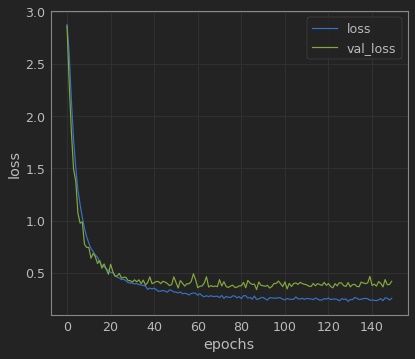

In [20]:
# import jtplot submodule from jupyterthemes
from jupyterthemes import jtplot

# currently installed theme will be used to
# set plot style if no arguments provided
jtplot.style()


plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend(["loss", "val_loss"])
plt.show()

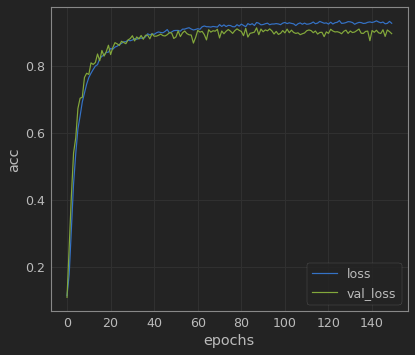

In [21]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.xlabel("epochs")
plt.ylabel("acc")
plt.legend(["loss", "val_loss"])
plt.show()

# 顯示預測結果圖片

In [269]:
def show_result(path, classes):
    F = plt.figure(1,(15,20))  ##定義整張圖大小
    grid = AxesGrid(F, 111, nrows_ncols=(5, 4), axes_pad=0, ngrids=None, label_mode="1")  ##畫 X*X 框
    
    for i in range(20):
        path_ = np.random.choice(glob.glob(path + "*.jpg"))
        image = cv2.imread(path_)
        pic = cv2.resize(image, (64, 64)).astype('float32') / 255.
        img_ = pic.reshape(1,64,64,3)
        pred = model.predict(img_)[0]
        pred_sort = sorted(["{} : {:.1f}%".format(classes[i].split("_")[0], pre * 100) for i, pre in enumerate(pred)], 
            key=lambda x: x.split(':')[1], reverse = True)[:3]  ##將預測的值取出前三位，及他們對應的人物名稱
        img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (352,352))
        cv2.rectangle(img, (0,270),(185,352),(255,255,255), -1)   ##畫一個白框
        font = cv2.FONT_HERSHEY_SIMPLEX
        for index, word in enumerate(pred_sort):   ##將預測結果顯示在圖片上
            cv2.putText(img, word, (10, 300 + index*20), font, 0.65,(0,0,0),2,cv2.LINE_AA)
        grid[i].grid("off")  ##關閉網格
        grid[i].imshow(img)
    plt.savefig('Result.png') ##對圖片進行存取
        

/home/user/anaconda3/envs/tensorflow/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


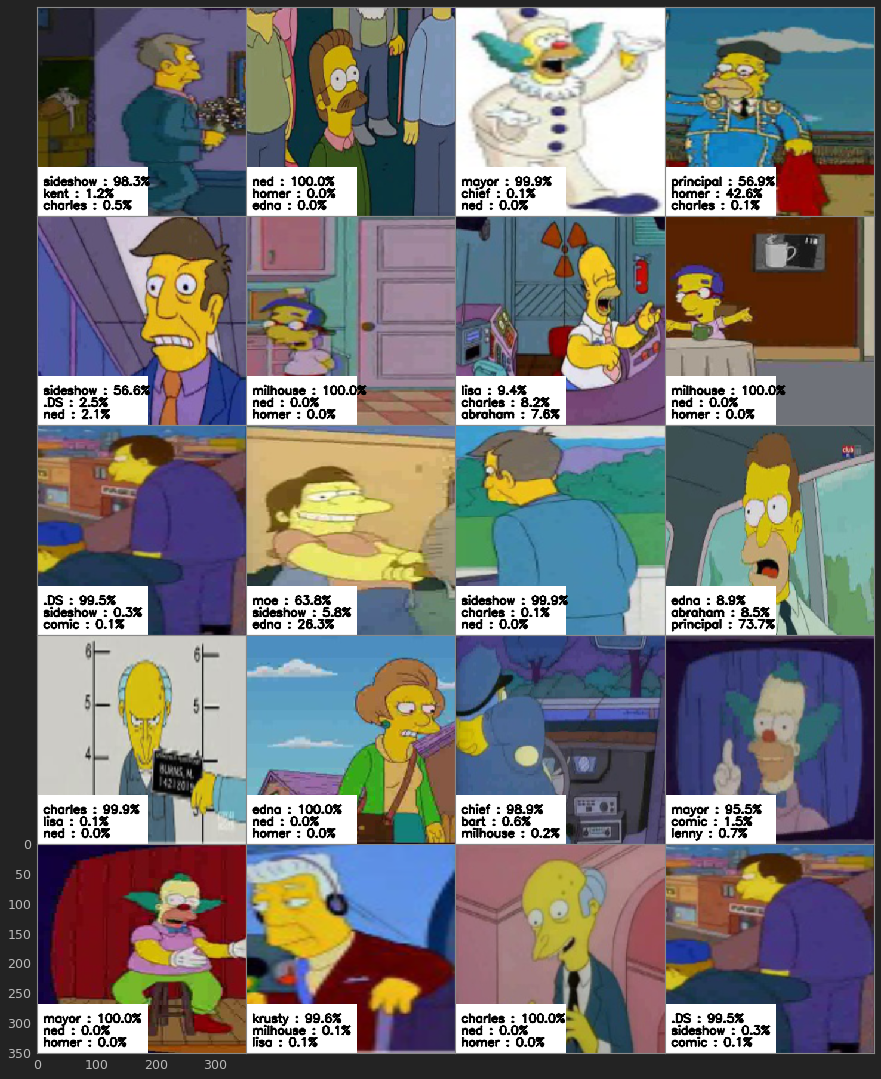

In [270]:
show_result(path="./test/", classes=classes)